In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import keras as keras
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import roc_auc_score

import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
print(keras.__version__)  # 2.2.4
print(tf.__version__)  # 1.15.0

2.2.4
1.15.0


# The SRGN fitting algorithm

The DCTR paper ([arXiv:1907.08209](https://arxiv.org/abs/1907.08209)) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at generator-level (before detector simulation) while the fit happens in simulation (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at simulation-level or both happen at generator-level.  This notebook illustrates the alternative SRGN procedure from [arXiv:2010.03569](https://arxiv.org/abs/2010.03569):

Let $x$ and $y$ denote the generator- and simulation-level events respectively. Suppose that $g$ is a neural network defined as follows:

$g_{\theta'}(y)=\text{argmax}_{g}\sum_{y_i\in\boldsymbol{\theta_?}}\log(g_{\theta'}(y_i))+
    \sum_{(x_i,y_i)\in\boldsymbol{\theta_0}}w_{\theta_0}(x_i,\theta')\log(1-g_{\theta'}(y_i))$

where $w_{\theta_0}(x,\theta') = f(x,\theta')/(1-f(x,\theta'))$ is a reweighting function learned at generator level (and $\theta_0$ denotes the nominal value of the parameter).  

Then, 

$\theta_{\text{SRGN}}^*\equiv\text{argmin}_{\theta'}\left[\Pr(g_{\theta_?}(y)>g_{\theta'}(y))\right]$

where the quantity in $[\cdot]$ is typically called the area under the receiver operating characteristic curve or AUC. We calculate the AUC between $g$’s predictions on events from the unknown sample and  $g$’s predictions on reweighted events from the synthetic sample; effectively, if we reweight events from the synthetic sample $\boldsymbol{\theta_0}$ to events from $\boldsymbol{\theta’}$, then we calculate the AUC between $g$’s predictions on  $\boldsymbol{\theta_?} $and $g$’s predictions on $\boldsymbol{\theta’}$.


The intuition of the above equation is that the classifier $g$ is trying to distinguish events from the unknown sample $\boldsymbol{\theta_?}$ and events from $\boldsymbol{\theta'}$ and we try to find a $\theta'$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples (i.e. the AUC is minimized), then the reweighting has worked! Asympotitically, the SRGN method learns the same result as the one in the body of the DCTR paper: $\theta^*=\theta_?$.

# Parton Shower Monte Carlo Tuning: aLund

In this notebook, we apply the SRGN fitting algorithm to the parton shower example from the original DCTR paper. Specifically, we attempt to tune the Monte Carlo parameter $\texttt{StringZ:aLund}$ (denoted $\text{aLund}$).

In [5]:
# Path to downloaded data from Zenodo
data_dir = '/data0/users/aandreassen/zenodo/'

### Utilities

In [6]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:, 0] > 0
    yphi_avg = np.average(x[mask, 1:3], weights=x[mask, 0], axis=0)
    x[mask, 1:3] -= yphi_avg
    x[mask, 0] /= x[:, 0].sum()

In [7]:
def preprocess_data(X):
    for x in X:
        normalize(x)

    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

## Training a DCTR Model
First, we need to train a DCTR model parameterized by aLund to provide us with a reweighting function to be used during fitting.

### Load training & validation data

In [8]:
# Load training data
dataset = np.load(data_dir + '1D_aLund_train.npz')

X = dataset['X']
Y = dataset['Y']

X = preprocess_data(X)
Y = to_categorical(Y, num_classes=2)

X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.1, shuffle=True)

### Build Model

In [9]:
# network architecture parameters
Phi_sizes = (100, 100, 128)
F_sizes = (100, 100, 100)

dctr = PFN(input_dim=7, Phi_sizes=Phi_sizes, F_sizes=F_sizes, summary=False)

### Train Model

In [10]:
# Train model
earlystopping = keras.callbacks.EarlyStopping(patience=10,
                                              verbose=1,
                                              restore_best_weights=True)

dctr.fit(X_train,
         Y_train,
         epochs=200,
         batch_size=1000,
         validation_data=(X_val, Y_val),
         verbose=1,
         callbacks=[earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1620000 samples, validate on 180000 samples
Epoch 1/100





1620000/1620000 [==============================] - 210s 130us/step - loss: 0.7013 - acc: 0.5014 - val_loss: 0.6937 - val_acc: 0.5025
Epoch 2/100
1620000/1620000 [==============================] - 207s 128us/step - loss: 0.6936 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5059
Epoch 3/100
1620000/1620000 [==============================] - 207s 128us/step - loss: 0.6932 - acc: 0.5048 - val_loss: 0.6930 - val_acc: 0.5031
Epoch 4/100
1620000/1620000 [==============================] - 208s 129us/step - loss: 0.6931 - acc: 0.5048 - val_loss: 0.6930 - val_acc: 0.5059
Epoch 5/100
1620000/1620000 [==============================] - 207s 128us/step - loss: 0.6931 - acc: 0.5045 - val_loss: 0.6931 - val_acc: 0.5021
Epoch 6/100
1620000/1620000 [==============================] - 208s 128us/step - loss: 0.6931 - acc: 0.5030 - val_loss: 

### Defining reweighting function

$w_{\theta_0}(x_i,\theta)=\frac{f(x_i,\theta)}{1-f(x_i,\theta)}$, where $f$  is a fully trained DCTR model.

Takes generator-level event $x_i$ from the synthetic sample $\boldsymbol{\theta_0}$ and weights it to an event from $\boldsymbol{\theta}$.

In [11]:
def reweight(events, param):  #from NN (DCTR)
    theta_prime = [0.1365, param, 0.217]

    # zip theta_prime to each input particle (but not to the padded rows)
    # check if pT != 0 --> zip theta_prime
    concat_input_and_params = np.where(
        np.abs(events[..., 0]) > 0, np.ones_like(events[..., 0]),
        np.zeros_like(events[..., 0]))

    concat_input_and_params = theta_prime * np.stack([
        concat_input_and_params, concat_input_and_params,
        concat_input_and_params
    ],
                                                     axis=-1)

    model_inputs = np.concatenate([events, concat_input_and_params], -1)

    f = dctr.model.predict(model_inputs, batch_size=100000)
    weights = (f[:, 1]) / (f[:, 0])

    return weights

## Validate DCTR for $\text{aLund}=0.8$

In [12]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}
plot_style_1 = {'alpha': 0.5, 'density': True}

# Define labels for legends
label_0 = r'aLund=0.68'

label_1 = r'aLund=0.80'

pythia_text = r'\textsc{Pythia 8}' + '\n' + r'$e^+e^- \to Z \to $ dijets' + '\n' + r"anti-$k_{\mathrm{T}}$, $R=0.8$"


def make_legend(ax):
    leg = ax.legend(frameon=False)
    leg.set_title(pythia_text, prop={'size': 14})
    leg._legend_box.align = "left"
    plt.tight_layout()

In [13]:
test_dataset_0 = np.load(data_dir + 'test1D_default.npz')
test_dataset_1 = np.load(data_dir + 'test1D_aLund.npz')

X0_test = preprocess_data(test_dataset_0['jet'][:, :, :4])
X1_test = preprocess_data(test_dataset_1['jet'][:, :, :4])

In [14]:
weights = reweight(X0_test, 0.80)

/home/asuresh/.local/lib/python3.5/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in log
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launche

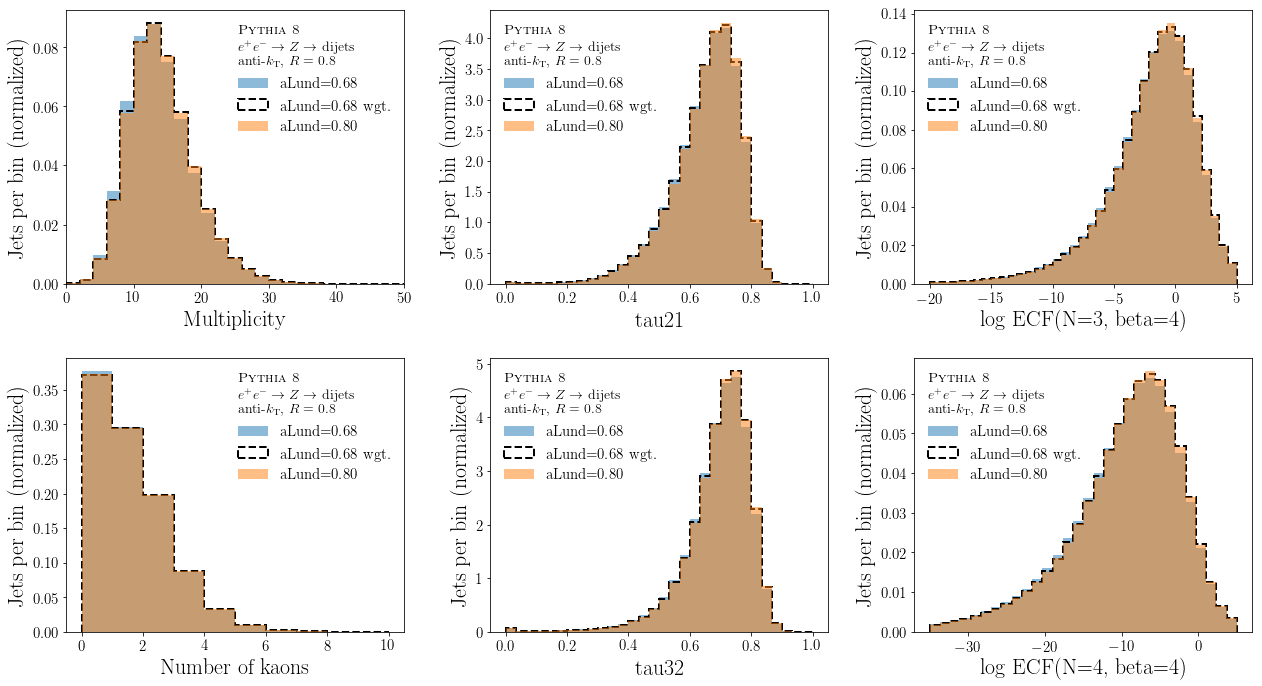

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)

bins = np.linspace(0, 50, 26)
ax[0, 0].hist(test_dataset_0['multiplicity'],
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[0, 0].hist(test_dataset_0['multiplicity'],
              bins=bins,
              label=label_0 + ' wgt.',
              weights=weights,
              **plot_style_0)
ax[0, 0].hist(test_dataset_1['multiplicity'],
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[0, 0].set_xlabel('Multiplicity')
ax[0, 0].set_ylabel('Jets per bin (normalized)')
ax[0, 0].set_xlim([0, 50])
make_legend(ax[0, 0])

bins = np.linspace(0, 10, 11)
ax[1, 0].hist(test_dataset_0['number_of_kaons'],
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[1, 0].hist(test_dataset_0['number_of_kaons'],
              bins=bins,
              label=label_0 + ' wgt.',
              weights=weights,
              **plot_style_0)
ax[1, 0].hist(test_dataset_1['number_of_kaons'],
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[1, 0].set_xlabel('Number of kaons')
ax[1, 0].set_ylabel('Jets per bin (normalized)')
make_legend(ax[1, 0])

bins = np.linspace(0, 1, 31)
ax[0, 1].hist(test_dataset_0['tau21'],
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[0, 1].hist(test_dataset_0['tau21'],
              bins=bins,
              label=label_0 + ' wgt.',
              weights=weights,
              **plot_style_0)
ax[0, 1].hist(test_dataset_1['tau21'],
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[0, 1].set_xlabel('tau21')
ax[0, 1].set_ylabel('Jets per bin (normalized)')
make_legend(ax[0, 1])

bins = np.linspace(0, 1, 31)
ax[1, 1].hist(test_dataset_0['tau32'],
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[1, 1].hist(test_dataset_0['tau32'],
              bins=bins,
              label=label_0 + ' wgt.',
              weights=weights,
              **plot_style_0)
ax[1, 1].hist(test_dataset_1['tau32'],
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[1, 1].set_xlabel('tau32')
ax[1, 1].set_ylabel('Jets per bin (normalized)')
make_legend(ax[1, 1])

bins = np.linspace(-20, 5, 36)
ax[0, 2].hist(np.log(test_dataset_0['ECF_N3_B4']),
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[0, 2].hist(np.log(test_dataset_0['ECF_N3_B4']),
              bins=bins,
              label=label_0 + ' wgt.',
              weights=weights,
              **plot_style_0)
ax[0, 2].hist(np.log(test_dataset_1['ECF_N3_B4']),
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[0, 2].set_xlabel('log ECF(N=3, beta=4)')
ax[0, 2].set_ylabel('Jets per bin (normalized)')
make_legend(ax[0, 2])

bins = np.linspace(-35, 5, 31)
ax[1, 2].hist(np.log(test_dataset_0['ECF_N4_B4']),
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[1, 2].hist(np.log(test_dataset_0['ECF_N4_B4']),
              bins=bins,
              label=label_0 + ' wgt.',
              weights=weights,
              **plot_style_0)
ax[1, 2].hist(np.log(test_dataset_1['ECF_N4_B4']),
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[1, 2].set_xlabel('log ECF(N=4, beta=4)')
ax[1, 2].set_ylabel('Jets per bin (normalized)')
make_legend(ax[1, 2])

# Fitting

## Setup the dataset

$\boldsymbol{\theta_0}$ denotes the synthetic sample used for reweighting, and we are trying to fit the parameter $\theta$ (in this case $\text{aLund}$) to the 'data' sample $\boldsymbol{\theta_?}$ (`theta_unknown`).

In [16]:
theta0 = X0_test  # aLund=0.68
theta_unknown = X1_test  # aLund=0.80

labels0 = np.zeros_like(theta0[:, 0, 0])
labels_unknown = np.ones_like(theta_unknown[:, 0, 0])

In [17]:
xvals = np.concatenate((theta0, theta_unknown), axis=0)

yvals = np.concatenate((labels0, labels_unknown), axis=0)

In [18]:
X_train, X_test, Y_train, Y_test = data_split(xvals,
                                              yvals,
                                              test=0.5,
                                              shuffle=True)

## Fitting Model: Scan

We will show for fixed $\theta$, the AUC is minimized when $\theta=\theta_?$.

### Creating Model

In [19]:
model = PFN(input_dim=4,
            Phi_sizes=Phi_sizes,
            F_sizes=F_sizes,
            output_dim=1,
            output_act='sigmoid',
            summary=True)

batch_size = 1000
earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

# scanning range for theta
thetas = np.linspace(0.5, 0.9, 9)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]               
__________________________________________________________________________________________________
activation

We will train this model with a weighted binary cross-entropy loss function:

$\text{loss}(g_{\theta'}(x))=-\sum_{x_i\in\boldsymbol{\theta_?}}\log(g_{\theta'}(x_i))-
    \sum_{x_i\in\boldsymbol{\theta_0}}w_{\theta_0}(x_{i},\theta')\log(1-g_{\theta'}(x_i))$

### Scan

In [20]:
def run_classifier(theta):

    weights_train = np.ones(len(X_train))
    weights_test = np.ones(len(X_test))

    # calculate weights for events in theta_0, but leave ones for events in theta_?
    weights_train[Y_train == 0] = reweight(events=X_train[Y_train == 0],
                                           param=theta)
    weights_test[Y_test == 0] = reweight(events=X_test[Y_test == 0],
                                         param=theta)

    model.model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

    # fit model on weighted binary cross-entropy
    history = model.fit(X_train,
                        Y_train,
                        epochs=200,
                        batch_size=batch_size,
                        validation_data=(X_test, Y_test, weights_test),
                        sample_weight=weights_train,
                        verbose=0,
                        callbacks=[earlystopping])

    # after training, calculate AUC between unknown sample and reweighted synthetic sample
    auc = roc_auc_score(np.concatenate((Y_train, Y_test)),
                        model.predict(np.concatenate((X_train, X_test)),
                                      batch_size=100000),
                        sample_weight=np.concatenate(
                            (weights_train, weights_test)))

    return auc

In [21]:
AUC = []

for theta in thetas:
    print("Testing theta = {:.2f}".format(theta))

    auc = run_classifier(theta)
    AUC += [auc]

    print("AUC: {:.2f}".format(auc))
    print("\n")
    pass

Testing theta = 0.50
AUC: 0.54


Testing theta = 0.55
AUC: 0.53


Testing theta = 0.60
AUC: 0.53


Testing theta = 0.65
AUC: 0.52


Testing theta = 0.70
AUC: 0.52


Testing theta = 0.75
AUC: 0.51


Testing theta = 0.80
AUC: 0.51


Testing theta = 0.85
AUC: 0.51


Testing theta = 0.90
AUC: 0.52




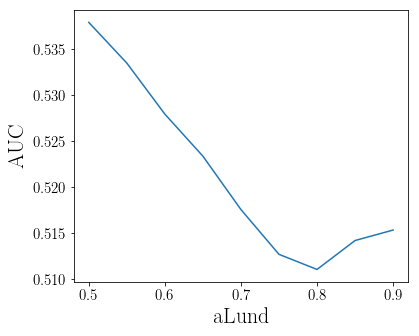

In [22]:
plt.figure(figsize=(6, 5))
plt.plot(thetas, AUC)
plt.xlabel(r'aLund')
plt.ylabel('AUC')
plt.show()

We've shown for fixed $\theta$, the AUC is minimized $\theta=\theta_?$.